In [1]:
# use kernel py3-6
#import goatools
from goatools import obo_parser
import re
import json
import numpy as np
import pandas as pd
from goatools.go_enrichment import GOEnrichmentStudy
import matplotlib.pyplot as plt
import os

In [2]:
def matchgff2(feature, gff_file='/home/t44p/PW_rawdata/Transciptome_GenomeAnnotation/Xele_annotated2_gff_export2.gff', obo_path="/home/t44p/PW_rawdata/go_obo/go.obo", namespace=None, depth_threshold=0, goea=False):
    """
    Searches a GFF (General Feature Format) file for specific features and retrieves associated Gene Ontology (GO) terms,
    with optional filtering by GO term namespace and depth.

    Parameters:
    ----------
    feature : list or iterable
        An iterable of strings representing the features to search for in the GFF file.

    gff_file : str, optional
        The file path to the GFF file. Defaults to a predefined path.

    obo_path : str, optional
        The file path to the Gene Ontology .obo file. Defaults to a predefined path.

    namespace : list of str or None, optional
        List of GO term namespaces to filter term count results. Valid options are 'biological_process', 
        'molecular_function', 'cellular_component', or None. Defaults to None (no filtering).

    depth_threshold : int, optional
        Minimum depth of GO terms to include in the results. Defaults to 0 (no filtering).

    goea : bool, optional
        Whether to perform Gene Ontology Enrichment Analysis. Defaults to False.

    Returns:
    -------
    tuple
        A tuple containing:
        1. A dictionary with features as keys and lists of lines from the GFF file as values.
        2. A dictionary mapping features to their associated GO terms.
        3. A dictionary of GO term counts.
        4. GOEA results (if goea is True), filtered by the specified depth threshold for all namespaces

    Notes:
    -----
    - The function uses regular expressions for precise matching of features.
    - It extracts GO IDs from matched lines and retrieves their corresponding names and namespaces.
    - It is possible for the rawcounts to filter for namespaces 
    - If `goea` is True, the function performs GO Enrichment Analysis and returns the results filtered by the specified depth threshold but not for namespaces. 
    - The Enrichment analysis will be performed across all namespaces, filtering parameter "namespace" will have no effect on the enrichment analysis
    
    """

    valid_namespaces = {'biological_process', 'molecular_function', 'cellular_component', None}
    # Check if namespace is a list containing only valid elements
    if isinstance(namespace, list) and not all(ns in valid_namespaces for ns in namespace):
        raise ValueError("Invalid namespace provided. Valid options are 'biological_process', "
                         "'molecular_function', 'cellular_component', or a list containing any of these. "
                         "You can also use None for no filtering.")

    with open(gff_file, 'r') as file:
        go_ontology = obo_parser.GODag(obo_path)
        
        lines_where_feat_found = {}
        go_ids = {}
        background_genes = []
        go_term_count = {}

         # Find the depth of each GO term
        go_depths = {go_id: go_term.depth for go_id, go_term in go_ontology.items()}

        # construct background genes
        if goea:
            for line in file:
                if not line.lstrip().startswith('#'):
                    background_genes.append(line.split('\t')[0])

        for feat in feature:
            file.seek(0)  # reset file pointer to the beginning for each feature
            lines_where_feat_found[feat] = []
            go_ids[feat] = {}
            pattern = re.compile(re.escape(feat) + r'\t')  # exact match followed by a tab
            for line in file:
                if pattern.search(line):
                    lines_where_feat_found[feat].append(line.strip())  # Store the line (as a string) if feature is found
                    # Extract GO id
                    match = re.search(r"Ontology_id=([GO:\d,]+)", line.strip())
                    if match:
                        ids = match.group(1).split(',')
                        # Map Terms to Ids and Count Occurrences
                        for id in ids:
                            term = go_ontology.get(id)
                            if term is not None:
                                go_ids[feat][id] = {'name': term.name, 'namespace': term.namespace}

                                if namespace is None or term.namespace in namespace and go_ontology[id].depth >= depth_threshold:
                                    # Count Occurrences
                                    if id in go_term_count:
                                        go_term_count[id] = (term.name, go_term_count[id][1] + 1, term.namespace)
                                    else:
                                        go_term_count[id] = (term.name, 1, term.namespace)
                            else:
                                go_ids[feat][id] = {'name': None, 'namespace': None}
                                if id not in go_term_count:
                                    go_term_count[id] = (None, 1)
        if goea:
            print("GO Enrichment Analysis >>")
            goea_obj = GOEnrichmentStudy(
                background_genes,
                go_ids,  # This needs to be a dict mapping gene IDs to a set of GO IDs
                go_ontology,
                propagate_counts=False,
                alpha=0.05,  # significance level for the statistical test
                methods=['fdr_bh']  # correction method for multiple testing
            )
            goea_result = goea_obj.run_study(go_ids.keys())

            # filter based on depth
            filtered_goea_results = [res for res in goea_result if res.goterm.depth >= depth_threshold]
            return lines_where_feat_found, go_ids, go_term_count, filtered_goea_results


        return lines_where_feat_found, go_ids, go_term_count
    

def tabulate(term_count_dict, sort=True):
    """
    Prints a tabulated view of the term counts from a dictionary, such as the one returned by matchgff2.

    Parameters:
    ----------
    term_count_dict : dict
        A dictionary where keys are Gene Ontology (GO) IDs, and values are tuples containing the GO term name, 
        the count of occurrences, and optionally the namespace. 
        The structure is typically: {GO_ID: (GO_Term, Count, Namespace)}.

    sort : bool, optional
        Whether to sort the output based on the count of occurrences of each GO term. Defaults to True.

    Description:
    ------------
    This function iterates through the term_count_dict and prints each GO term's count, ID, name, and namespace 
    in a tabular format. It can optionally sort these terms based on their count in descending order.

    Note:
    -----
    The function is primarily a utility for visualizing the output of the matchgff2 function. It does not return any value 
    but prints the information directly to the console.

    Example Usage:
    --------------
    go_term_count = {'GO:0000001': ('term1', 5, 'biological_process'), 'GO:0000002': ('term2', 3, 'cellular_component')}
    tabulate(go_term_count, sort=True)
    """
    print(f"count\tGO ID\tGO Term\tnamespace")

    # Conditionally sort the dictionary if required
    items = sorted(term_count_dict.items(), key=lambda x: x[1][1], reverse=True) if sort else term_count_dict.items()

    for goid, values in items:
        count = values[1]
        term = values[0] if values[0] is not None else "N/A"
        namespace = values[2] if len(values) > 2 else "N/A"

        print(f"{count}\t{goid}\t{term}\t{namespace}")
    #return 


### load clusters

for each cluster selected by the predictor the GO Terms need to be gathered.

In [3]:
with open("/home/t44p/PW_rawdata/results/wgcna_clusters.json", 'r') as file:
    clusters = json.load(file)

### distribution of cluster selected as through cumulative feature importance


In [43]:
lasso_gc_num_imp_clust = []
lasso_lc_num_imp_clust = []
path_gc = "/home/t44p/PW_rawdata/results/newfeat_lasso/gcms/"
path_lc ="/home/t44p/PW_rawdata/results/newfeat_lasso/lcms/"
# Iterate over each file in the directory
for p in [path_gc, path_lc]:

    for file in os.listdir(p):
        if file.endswith(".json") and not(file.startswith('gcms_dict_nXcv') or file.startswith('lcms_dict_nXcv')):
            file_path = os.path.join(p, file)
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)
            if p == path_gc:
                lasso_gc_num_imp_clust.append(len(data['selected_features']))
            if p == path_lc:
                lasso_lc_num_imp_clust.append(len(data['selected_features']))


In [34]:
rfr_gc_num_imp_clust = []
rfr_lc_num_imp_clust = []
path_gc = "/home/t44p/PW_rawdata/results/newfeat_rfr/gcms/"
path_lc ="/home/t44p/PW_rawdata/results/newfeat_rfr/lcms/"
# Iterate over each file in the directory
for p in [path_gc, path_lc]:

    for file in os.listdir(p):
        if file.endswith(".json") and not(file.startswith('gcms_dict_nXcv') or file.startswith('lcms_dict_nXcv')):
            file_path = os.path.join(p, file)
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)
            if p == path_gc:
                rfr_gc_num_imp_clust.append(len(data['selected_features']))
            if p == path_lc:
                rfr_lc_num_imp_clust.append(len(data['selected_features']))

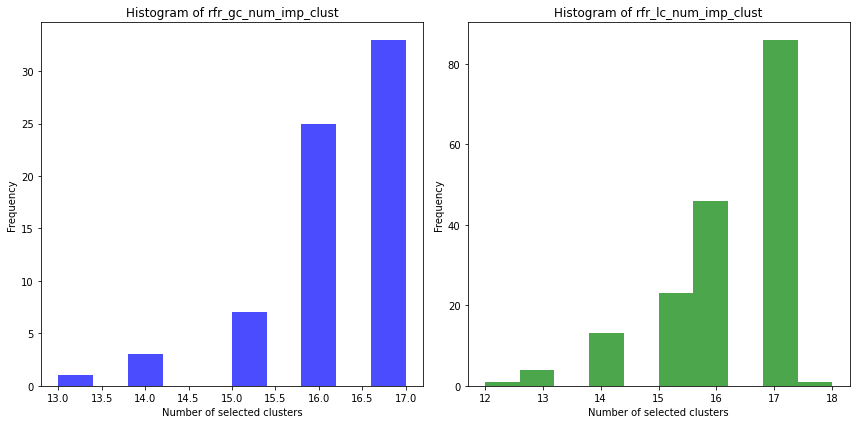

In [47]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for rfr_gc_num_imp_clust
axs[0].hist(rfr_gc_num_imp_clust, bins=10, color='blue', alpha=0.7)
axs[0].set_title('Histogram of rfr_gc_num_imp_clust')
axs[0].set_xlabel('Number of selected clusters')
axs[0].set_ylabel('Frequency')

# Plot histogram for rfr_lc_num_imp_clust
axs[1].hist(rfr_lc_num_imp_clust, bins=10, color='green', alpha=0.7)
axs[1].set_title('Histogram of rfr_lc_num_imp_clust')
axs[1].set_xlabel('Number of selected clusters')
axs[1].set_ylabel('Frequency')

# Display the plot
plt.tight_layout()
plt.show()


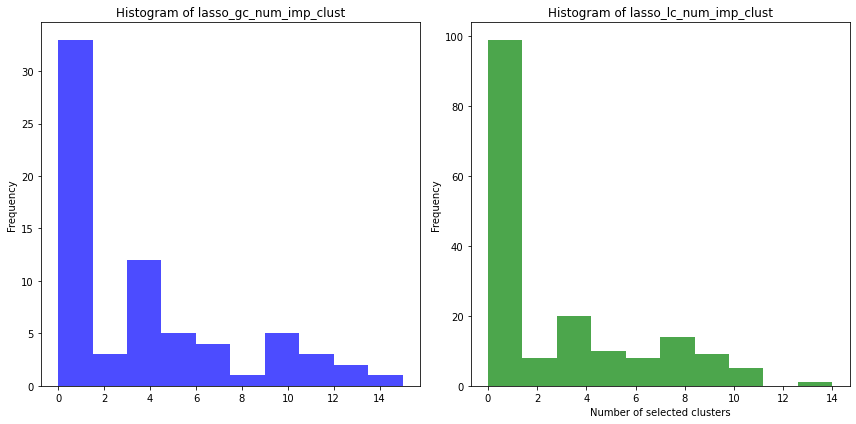

In [48]:
import matplotlib.pyplot as plt


# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for rfr_gc_num_imp_clust
axs[0].hist(lasso_gc_num_imp_clust, bins=10, color='blue', alpha=0.7)
axs[0].set_title('Histogram of lasso_gc_num_imp_clust')
axs[1].set_xlabel('Number of selected clusters')
axs[0].set_ylabel('Frequency')

# Plot histogram for rfr_lc_num_imp_clust
axs[1].hist(lasso_lc_num_imp_clust, bins=10, color='green', alpha=0.7)
axs[1].set_title('Histogram of lasso_lc_num_imp_clust')
axs[1].set_xlabel('Number of selected clusters')
axs[1].set_ylabel('Frequency')

# Display the plot
plt.tight_layout()
plt.show()


### create common features

for each predictor and the selected features represent the clusters.
gather for each cluster the gene_ids and concile them into common_features

In [5]:
with open("/home/t44p/PW_rawdata/results/newfeat_rfr/gcms/alanine_beta_248_290_rt6_44_nXcv.json", 'r') as file:
    ala_beta = json.load(file)
sel_features = [feature[2:] for feature in ala_beta['selected_features']]


In [45]:
ala_beta['selected_features']

['MEdarkred',
 'MEdimgrey',
 'MEtomato',
 'MEsalmon',
 'MErosybrown',
 'MEsaddlebrown',
 'MEred',
 'MEorangered',
 'MEmaroon',
 'MEblack',
 'MEchocolate',
 'MEmistyrose',
 'MEperu',
 'MElinen',
 'MEdarkgrey',
 'MEsienna',
 'MEseashell']

In [13]:
common_features = []
for c in sel_features:
    common_features.extend(list(clusters[c]))
    #print(clusters[c])

In [14]:
len(common_features)

20576

In [50]:
with open("/home/t44p/PW_rawdata/results/newfeat_rfr/lcms/lcms_dict_nXcv.json", 'r') as json_file:
    lcms_prefix = json.load(json_file)
with open("/home/t44p/PW_rawdata/results/newfeat_rfr/gcms/gcms_dict_nXcv.json", 'r') as json_file:
    gcms_prefix = json.load(json_file)

In [49]:
path_gc = "/home/t44p/PW_rawdata/results/newfeat_rfr/gcms/"
path_lc ="/home/t44p/PW_rawdata/results/newfeat_rfr/lcms/"
# Iterate over each file in the directory
for p in [path_gc, path_lc]:
    for file in os.listdir(p):
        if file.endswith(".json") and not(file.startswith('gcms_dict_nXcv') or file.startswith('lcms_dict_nXcv')):
            file_path = os.path.join(p, file)
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)
            if p == path_gc:
                #rfr_gc_num_imp_clust.append(len(data['selected_features']))
                print(file)
            if p == path_lc:
                #rfr_lc_num_imp_clust.append(len(data['selected_features']))
                print(file)



Cellobiose_361_204_rt14_40_nXcv.json
tyrosine_218_280_rt10_78_nXcv.json
threonic_acid_292_220_rt7_49_nXcv.json
isoleucin_158_233_rt_5_21_nXcv.json
asparagine_116_188_rt9_00_nXcv.json
adenine_264_279_rt11_12_nXcv.json
glycerol_117_205_rt4_75_nXcv.json
raffinose_437_451_rt16_91_nXcv.json
adenosine_5_monophosphate_169__nXcv.json
ornithine_142_174_rt9_34_nXcv.json
glucose_160_rt9_81_nXcv.json
inositol_myo_305_265_rt10_71_nXcv.json
phosphoric_acid_314_299_rt_5_4_nXcv.json
sucrose_437_361_rt13_77_nXcv.json
hexose_307_217_rt9_58_nXcv.json
alanine_3_cyano_141_100_rt6_78_nXcv.json
threonine_219_291_rt6_01_nXcv.json
tryptophan_202_291_rt12_94_nXcv.json
citric_acid_273_375_rt9_72_nXcv.json
alanine_116_218_rt3_38_nXcv.json
glucose_1_phosphate_217_rt9_16_nXcv.json
leucine_158_232_rt4_97_nXcv.json
trehalose_alpha_alpha_191_169__nXcv.json
quinic_acid_255_345_rt9_45_nXcv.json
Oxalic_acid_219_147_3_94_nXcv.json
valine_144_218_rt4_42_nXcv.json
dopamine_174_426_rt11_11_nXcv.json
galactinol_204_191_rt15_3

In [ ]:
path_gc = "/home/t44p/PW_rawdata/results/newfeat_lasso/gcms/"
path_lc ="/home/t44p/PW_rawdata/results/newfeat_lasso/lcms/"
# Iterate over each file in the directory
for p in [path_gc, path_lc]:
    for file in os.listdir(p):
        if file.endswith(".json") and not(file.startswith('gcms_dict_nXcv') or file.startswith('lcms_dict_nXcv')):
            file_path = os.path.join(p, file)
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)
            if p == path_gc:
                #  
            if p == path_lc:
                #l;k